
# Plant Disease Detection Using Transfer Learning with ResNet50


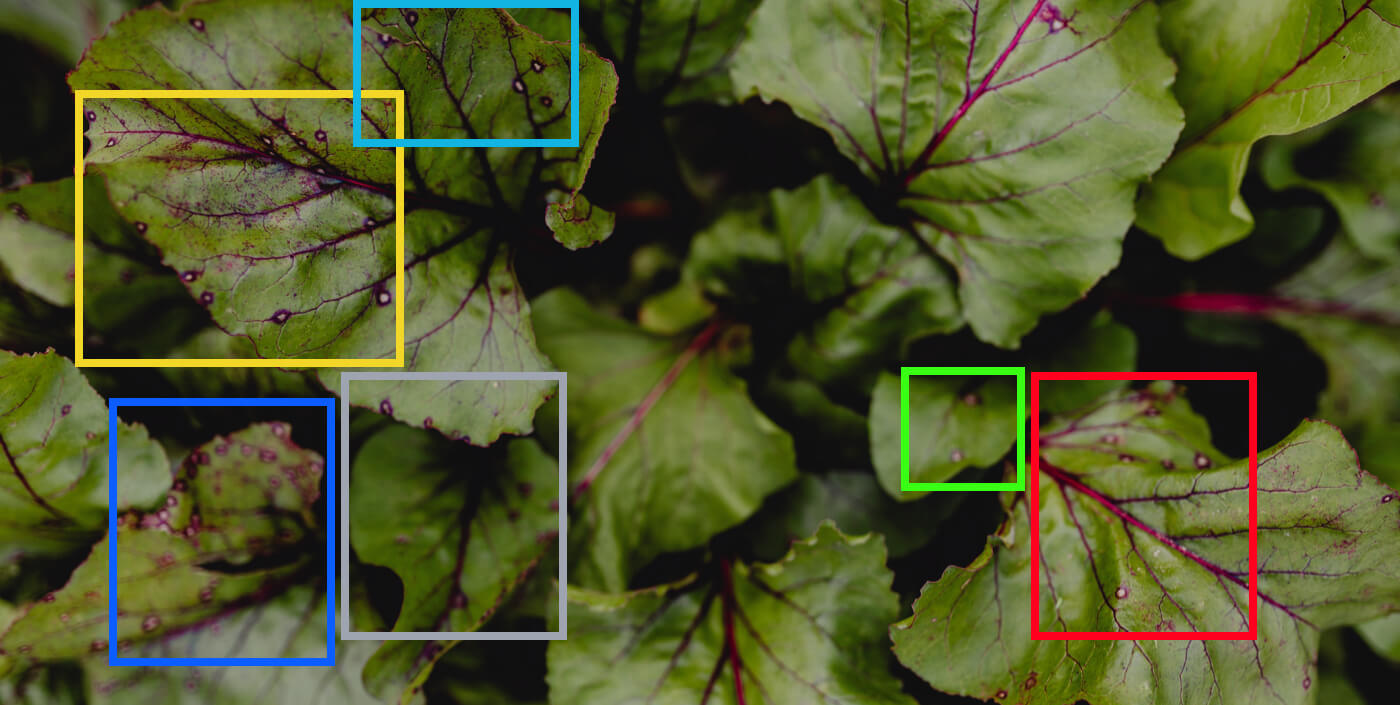

Plant diseases pose a significant threat to agricultural productivity and food security worldwide. Early detection and accurate diagnosis of plant diseases are crucial for effective management and mitigation. Traditional methods of disease detection can be time-consuming and require expert knowledge. However, advancements in machine learning, particularly deep learning, have opened new avenues for automated and accurate plant disease detection.

In this project, we leverage transfer learning using a pre-trained ResNet50 model to detect plant diseases from images. The model is fine-tuned to classify plant leaves as either healthy or diseased. By utilizing data augmentation techniques and handling imbalanced data with class weights, we aim to improve the model's performance and reliability. This approach can significantly enhance the speed and accuracy of plant disease detection, aiding farmers and agricultural experts in taking timely action to protect crops and improve yields.

### Step 1: Set Up the Environment

**Concept: Environment Setup**

Setting up the environment involves importing necessary libraries and preparing the workspace.

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
from zipfile import ZipFile
from sklearn.utils import class_weight

### Step 2: Data Preprocessing

**Concept: Data Preparation**

Data preprocessing includes extracting the dataset, setting up data augmentation, and creating data generators.


In [ ]:
# Unzipping the dataset
with ZipFile("Plant disease detection  Dataset.zip", 'r') as zip_ref:
    zip_ref.extractall()

print(os.listdir("Plant disease detection  Dataset"))

data_dir = 'Plant disease detection  Dataset'

['Healthy', 'Diseased ', '.DS_Store']


In [ ]:
# Data Augmentation and Image Data Generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.2  # 20% of the data for validation
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)


Found 329 images belonging to 2 classes.
Found 81 images belonging to 2 classes.


**Concept: Class Weight Calculation**

Handles imbalanced data by computing weights for each class.

In [ ]:
# Checking class distribution
class_labels = train_generator.class_indices
print("Class labels:", class_labels)
classes = list(train_generator.class_indices.keys())

# Calculating class weights to handle imbalanced data
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}
print("Class weights:", class_weights)

Class labels: {'Diseased ': 0, 'Healthy': 1}
Class weights: {0: 0.5633561643835616, 1: 4.445945945945946}


### Step 3: Model Building with Transfer Learning

**Concept: Transfer Learning**

Using a pre-trained model (ResNet50) as a starting point and fine-tuning it for the specific task.



In [ ]:
# Load the pre-trained ResNet50 model without the top classification layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze some layers of the base model for fine-tuning
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])


94765736/94765736 [==============================] - 4s 0us/step


### Step 4: Model Training

**Concept: Model Training**

Training the model with the training data and validating it using validation data. Adjustments include increasing epochs and using class weights.


In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=20,
    class_weight=class_weights
    class_weight=class_weights   # Added class weights to handle imbalanced data
)

Epoch 1/20
10/10 [==============================] - 53s 977ms/step - loss: 0.8556 - accuracy: 0.7508 - val_loss: 0.3920 - val_accuracy: 0.8750
Epoch 2/20
10/10 [==============================] - 7s 627ms/step - loss: 0.6118 - accuracy: 0.7205 - val_loss: 0.3834 - val_accuracy: 0.8750
Epoch 3/20
10/10 [==============================] - 8s 869ms/step - loss: 0.4934 - accuracy: 0.7475 - val_loss: 0.3162 - val_accuracy: 0.9219
Epoch 4/20
10/10 [==============================] - 6s 631ms/step - loss: 0.3843 - accuracy: 0.7811 - val_loss: 0.3723 - val_accuracy: 0.8906
Epoch 5/20
10/10 [==============================] - 7s 649ms/step - loss: 0.3535 - accuracy: 0.8586 - val_loss: 0.3771 - val_accuracy: 0.9062
Epoch 6/20
10/10 [==============================] - 7s 749ms/step - loss: 0.3066 - accuracy: 0.8586 - val_loss: 0.3694 - val_accuracy: 0.8906
Epoch 7/20
10/10 [==============================] - 6s 623ms/step - loss: 0.3306 - accuracy: 0.8754 - val_loss: 0.2852 - val_accuracy: 0.9062
Epoch

### Step 5: Evaluation

**Concept: Model Evaluation**

Evaluating the trained model using validation data and plotting accuracy and loss.

In [ ]:

val_loss, val_accuracy = model.evaluate(validation_generator)
val_accuracy_percent = val_accuracy * 100
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy_percent:.2f}%')

3/3 [==============================] - 1s 313ms/step - loss: 1.1282 - accuracy: 0.8889
Validation Loss: 1.1281652450561523
Validation Accuracy: 88.89%


**Plotting training and validation accuracy**




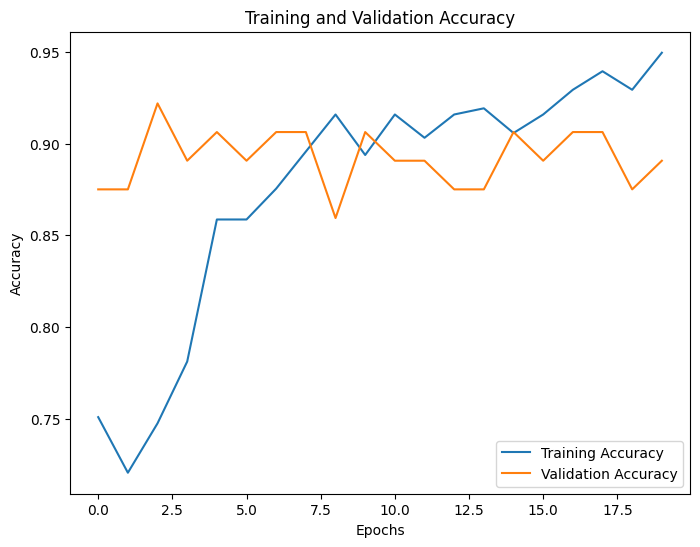

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(8, 6))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()



**Plotting training and validation loss**

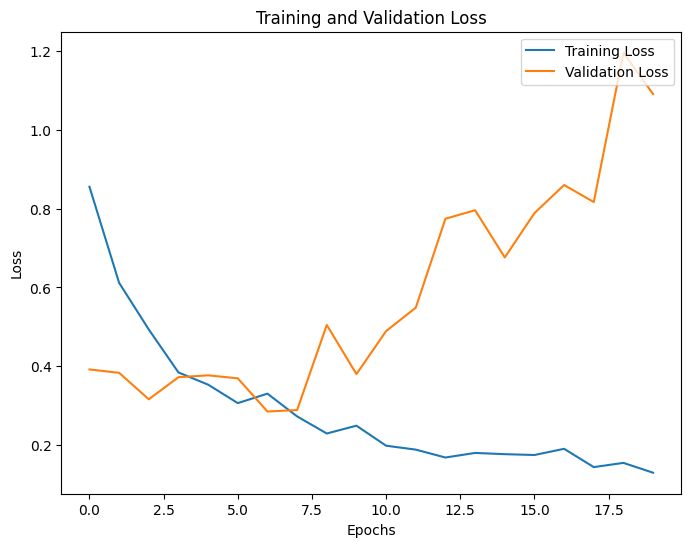

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

### Step 6: Prediction

**Concept: Model Prediction**

Loading a new image and using the trained model to predict whether it is healthy or diseased.


Threshold: The threshold is set at 0.5, which is standard for binary classification. If the prediction is below 0.5, the plant is classified as "Healthy"; otherwise, it is classified as "Diseased".

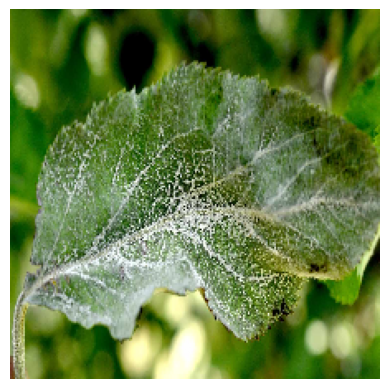

1/1 [==============================] - 0s 23ms/step
Prediction: Diseased


In [ ]:
from tensorflow.keras.preprocessing import image

def load_image(img_path, show=False):
    img = image.load_img(img_path, target_size=(224, 224))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels)
    img_tensor /= 255.                                      # rescale by 1/255

    if show:
        plt.imshow(img_tensor[0])
        plt.axis('off')
        plt.show()

    return img_tensor

new_image = load_image('/content/Apple_img.jpg', show=True)
pred = model.predict(new_image)
print(f'Prediction: {"Healthy" if pred < 0.5 else "Diseased"}')

## Conclusion

Using transfer learning with the ResNet50 model, this project demonstrates a viable approach for automating plant disease detection. Fine-tuning the model, applying data augmentation, and addressing class imbalance with class weights significantly improved the model's accuracy. The resulting system provides a fast, reliable, and scalable solution for detecting plant diseases, which can greatly benefit farmers and agricultural experts by enabling early intervention and improving crop health management. Further enhancements, such as training on larger datasets and exploring additional pre-trained models, could yield even better performance.*italicized text*

**The model's performance improved by:**

1. Using a more robust pre-trained model (ResNet50 in this case).
2. Fine-tuning more layers.
3. Handling imbalanced data using class weights.
4. Training for more epochs to ensure better learning.